In [1]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, models, datasets
from torchvision.datasets import ImageFolder
import splitfolders
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from tqdm.notebook import tqdm
import random
from PIL import Image

# Проверка GPU
input_folder = r"C:\Users\madik\OneDrive\Рабочий стол\Images"

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


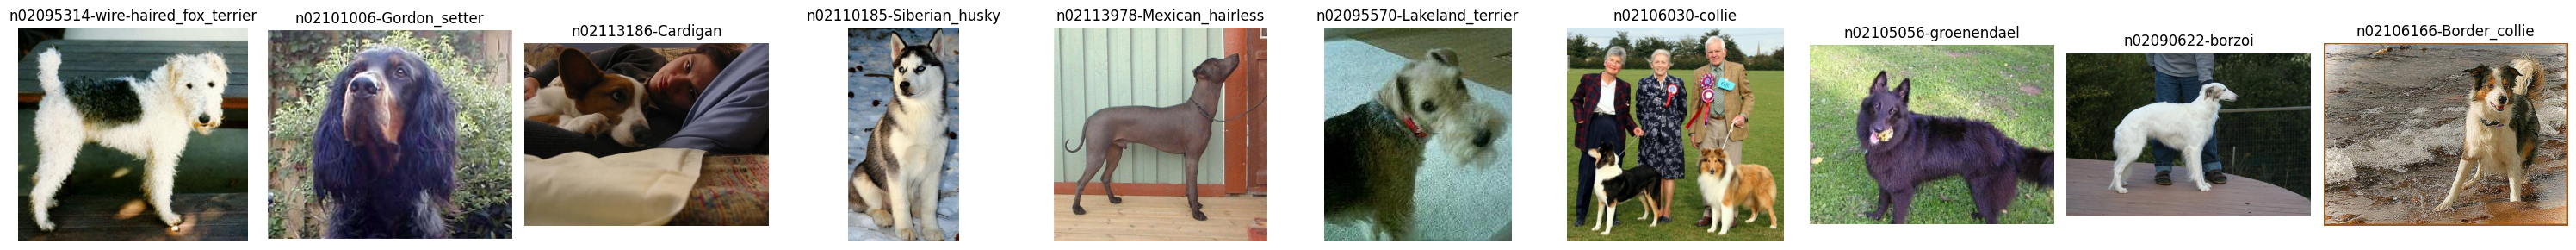

In [2]:
def visualize_classes(image_folder, max_classes=10):
    class_folders = [f for f in os.listdir(image_folder) if os.path.isdir(os.path.join(image_folder, f))]
    random.shuffle(class_folders)  

    num_classes = min(len(class_folders), max_classes)  
    plt.figure(figsize=(num_classes * 3, 3))

    for i, class_name in enumerate(class_folders[:num_classes]):
        class_path = os.path.join(image_folder, class_name)
        image_files = [f for f in os.listdir(class_path) if f.endswith((".png", ".jpg", ".jpeg"))]

        if not image_files:
            continue  

        image_path = os.path.join(class_path, random.choice(image_files))  
        img = Image.open(image_path).convert("RGB")

        plt.subplot(1, num_classes, i + 1)
        plt.imshow(img)
        plt.title(class_name, fontsize=12)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


visualize_classes(input_folder)

Copying files: 0 files [00:00, ? files/s]

Copying files: 20580 files [02:05, 163.66 files/s]


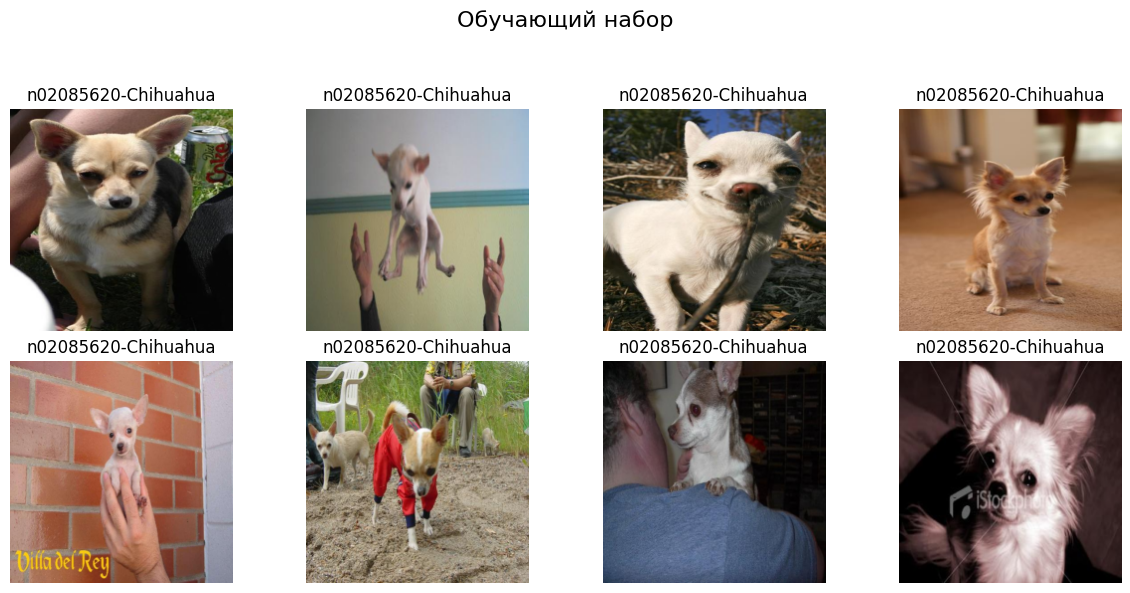

In [3]:

output_folder = "split_data"  

splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(0.7, 0.15, 0.15),
    group_prefix=None
)


basic_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Создание датасетов через ImageFolder
train_dataset = datasets.ImageFolder(os.path.join(output_folder, "train"), transform=basic_transform)
val_dataset   = datasets.ImageFolder(os.path.join(output_folder, "val"), transform=basic_transform)
test_dataset  = datasets.ImageFolder(os.path.join(output_folder, "test"), transform=basic_transform)

# Функция денормализации для визуализации
def denormalize(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return tensor * std + mean

# Визуализация первых 8 изображений из обучающего набора
plt.figure(figsize=(12, 6))
for i in range(8):
    img, label = train_dataset[i]
    plt.subplot(2, 4, i+1)
    plt.imshow(denormalize(img).permute(1,2,0))
    plt.title(train_dataset.classes[label])
    plt.axis("off")
plt.suptitle("Обучающий набор", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()

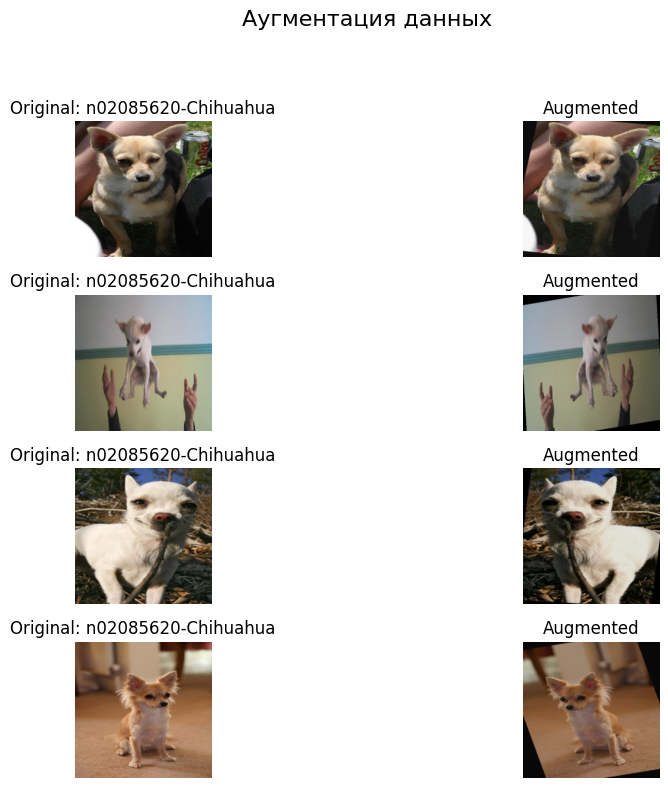

In [4]:
aug_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

aug_dataset = datasets.ImageFolder(os.path.join(output_folder, "train"), transform=aug_transform)


plt.figure(figsize=(12, 8))
for i in range(4):
    # Оригинал
    img, label = train_dataset[i]
    plt.subplot(4, 2, 2*i+1)
    plt.imshow(denormalize(img).permute(1,2,0))
    plt.title(f"Original: {train_dataset.classes[label]}")
    plt.axis("off")
    # Аугментированный вариант
    img_aug, _ = aug_dataset[i]
    plt.subplot(4, 2, 2*i+2)
    plt.imshow(denormalize(img_aug).permute(1,2,0))
    plt.title("Augmented")
    plt.axis("off")
plt.suptitle("Аугментация данных", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.93])
plt.show()


In [33]:
model = models.resnet18(pretrained=True)

# Замораживаем все слои
for param in model.parameters():
    param.requires_grad = False


num_classes = len(train_dataset.classes)
model.fc = nn.Sequential(
    nn.Dropout(p=0.2),  
    nn.Linear(model.fc.in_features, num_classes)
)
model = model.to(device)

print(model)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Настройка функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=1)


scaler = torch.amp.GradScaler('cuda')

# Обновленные функции обучения и валидации с поддержкой AMP и градиентного отсечения
def train_epoch(model, loader, optimizer, criterion, scaler):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in tqdm(loader, desc="Training", leave=False):
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        with torch.amp.autocast('cuda'):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
        
        # Обратный проход с масштабированием
        scaler.scale(loss).backward()
        # Расмасштабирование градиентов для отсечения
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        
        total_loss += loss.item() * inputs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    return total_loss / total, correct / total

def validate(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in tqdm(loader, desc="Validating", leave=False):
            inputs = inputs.to(device)
            labels = labels.to(device)
            with torch.amp.autocast('cuda'):
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
            
    return total_loss / total, correct / total



==== Этап 1: Обучение (тренировка только последнего слоя) ====

Epoch 1/5


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.7100 | Val Loss: 0.8622
Train Acc: 0.7856  | Val Acc: 0.7355

Epoch 2/5


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.7073 | Val Loss: 0.8486
Train Acc: 0.7878  | Val Acc: 0.7431

Epoch 3/5


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.7134 | Val Loss: 0.8514
Train Acc: 0.7876  | Val Acc: 0.7395

Epoch 4/5


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.7120 | Val Loss: 0.8541
Train Acc: 0.7877  | Val Acc: 0.7388

Epoch 5/5


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.7075 | Val Loss: 0.8519
Train Acc: 0.7882  | Val Acc: 0.7421


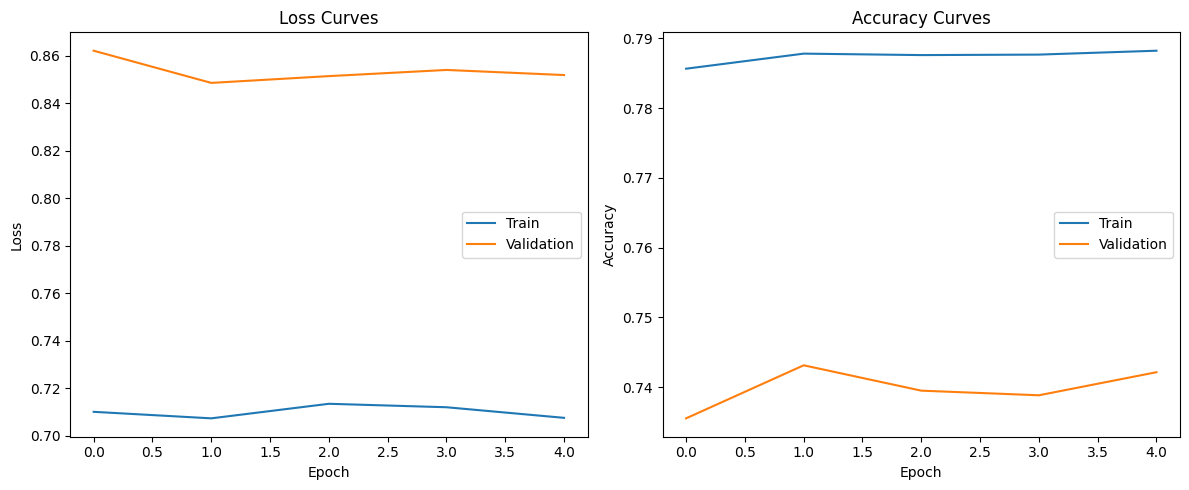

In [40]:
best_val_acc = 0.0
train_losses = []
val_losses = []
train_accs = []
val_accs = []

print("\n==== Этап 1: Обучение (тренировка только последнего слоя) ====")
for epoch in range(5):
    print(f"\nEpoch {epoch+1}/5")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_acc     = validate(model, val_loader, criterion)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    
    scheduler.step(val_loss)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_phase1.pth")
    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f}  | Val Acc: {val_acc:.4f}")


plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label="Train")
plt.plot(val_losses, label="Validation")
plt.title("Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accs, label="Train")
plt.plot(val_accs, label="Validation")
plt.title("Accuracy Curves")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.tight_layout()
plt.show()


In [41]:
for param in model.layer4.parameters():
    param.requires_grad = True

# Обновляем оптимизатор для fine-tuning (с меньшей скоростью обучения)
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=1)
scaler = torch.amp.GradScaler('cuda')
  # создаем новый scaler для fine-tuning

best_val_acc_ft = 0.0

print("\n==== Этап 2: Fine-tuning (разморозка последних блоков) ====")
for epoch in range(5):
    print(f"\nFine-tuning Epoch {epoch+1}/5")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion, scaler)
    val_loss, val_acc     = validate(model, val_loader, criterion)
    
    if val_acc > best_val_acc_ft:
        best_val_acc_ft = val_acc
        torch.save(model.state_dict(), "best_phase2.pth")
    
    scheduler.step(val_loss)
    
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f}  | Val Acc: {val_acc:.4f}")



==== Этап 2: Fine-tuning (разморозка последних блоков) ====

Fine-tuning Epoch 1/5


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.7027 | Val Loss: 0.8396
Train Acc: 0.7902  | Val Acc: 0.7441

Fine-tuning Epoch 2/5


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.7088 | Val Loss: 0.8476
Train Acc: 0.7901  | Val Acc: 0.7392

Fine-tuning Epoch 3/5


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.6962 | Val Loss: 0.8546
Train Acc: 0.7931  | Val Acc: 0.7369

Fine-tuning Epoch 4/5


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.7031 | Val Loss: 0.8561
Train Acc: 0.7868  | Val Acc: 0.7438

Fine-tuning Epoch 5/5


Training:   0%|          | 0/449 [00:00<?, ?it/s]

Validating:   0%|          | 0/95 [00:00<?, ?it/s]

Train Loss: 0.6904 | Val Loss: 0.8453
Train Acc: 0.7912  | Val Acc: 0.7445


Testing:   0%|          | 0/100 [00:00<?, ?it/s]


Classification Report:
                                          precision    recall  f1-score   support

                     n02085620-Chihuahua       0.75      0.50      0.60        24
              n02085782-Japanese_spaniel       0.92      0.79      0.85        29
                   n02085936-Maltese_dog       0.73      0.90      0.80        39
                      n02086079-Pekinese       0.88      0.61      0.72        23
                      n02086240-Shih-Tzu       0.67      0.67      0.67        33
              n02086646-Blenheim_spaniel       0.74      0.86      0.79        29
                      n02086910-papillon       0.88      0.97      0.92        30
                   n02087046-toy_terrier       0.55      0.59      0.57        27
           n02087394-Rhodesian_ridgeback       0.68      0.63      0.65        27
                  n02088094-Afghan_hound       0.97      0.81      0.88        37
                        n02088238-basset       0.91      0.74      0.82  

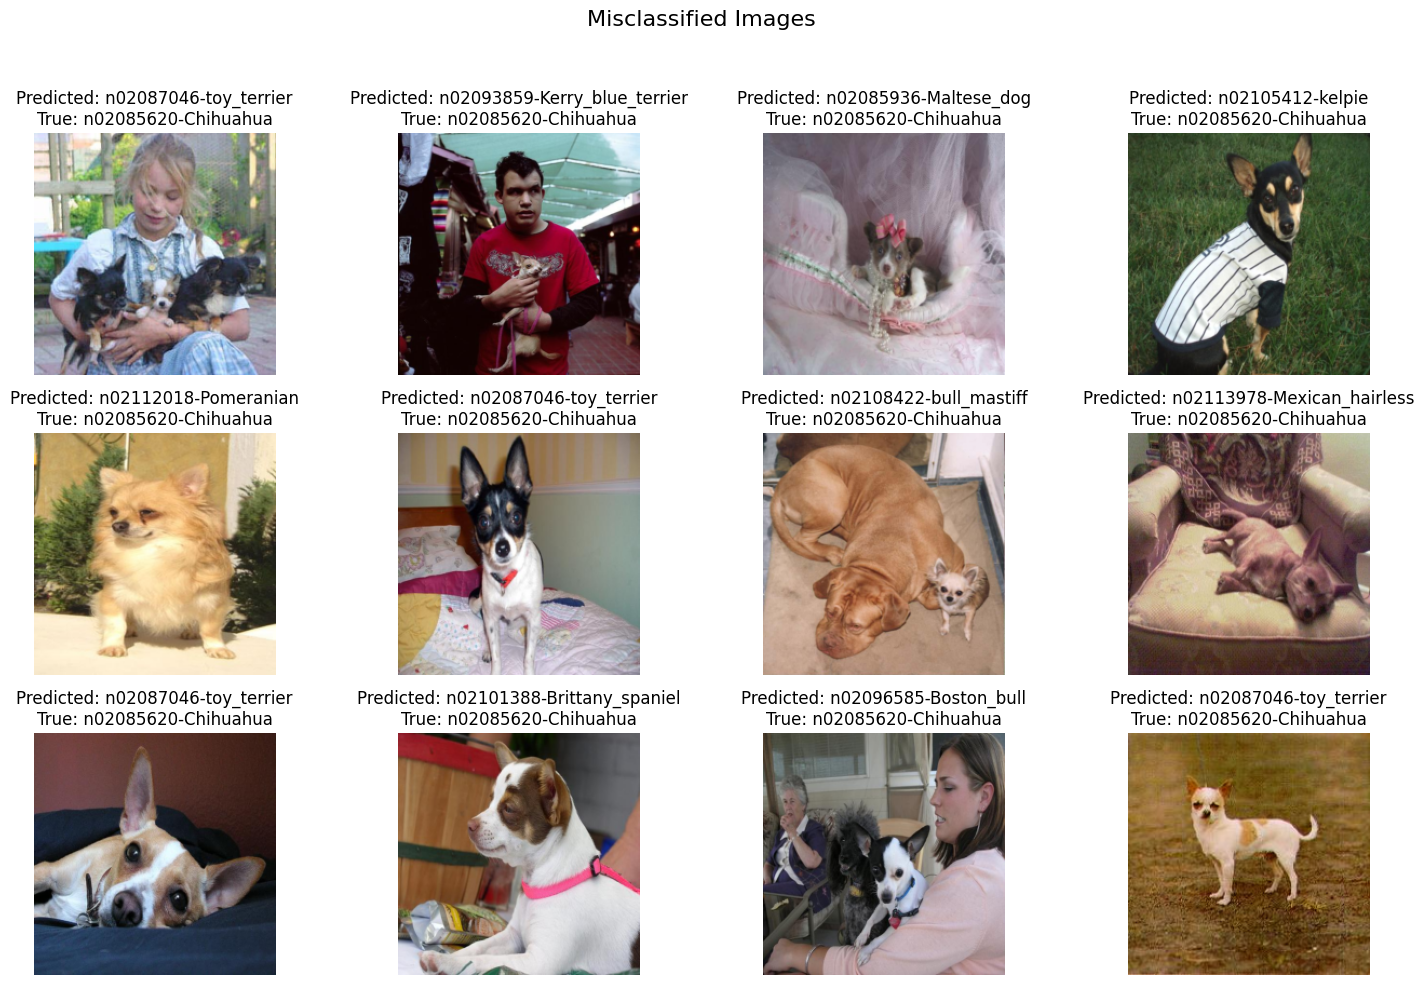

In [43]:
model.load_state_dict(torch.load("best_phase2.pth"))
model.eval()

all_predictions = []
all_ground_truth = []
misclassified_samples = []

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        with torch.amp.autocast('cuda'):
            outputs = model(inputs)
        _, predicted_classes = outputs.max(1)

        all_predictions.extend(predicted_classes.cpu().numpy())
        all_ground_truth.extend(labels.cpu().numpy())

        
        misclassification_mask = (predicted_classes != labels)
        for img, pred_cls, true_cls in zip(inputs[misclassification_mask],
                                            predicted_classes[misclassification_mask],
                                            labels[misclassification_mask]):
            misclassified_samples.append((
                denormalize(img.cpu()).permute(1, 2, 0).numpy(),
                train_dataset.classes[pred_cls.item()],
                train_dataset.classes[true_cls.item()]
            ))

from sklearn.metrics import classification_report

print("\nClassification Report:")
print(classification_report(all_ground_truth, all_predictions,
                            target_names=train_dataset.classes))



import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))
for index in range(min(12, len(misclassified_samples))):
    plt.subplot(3, 4, index + 1)
    plt.imshow(misclassified_samples[index][0])
    plt.title(f"Predicted: {misclassified_samples[index][1]}\n"
              f"True: {misclassified_samples[index][2]}")
    plt.axis("off")
plt.suptitle("Misclassified Images", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


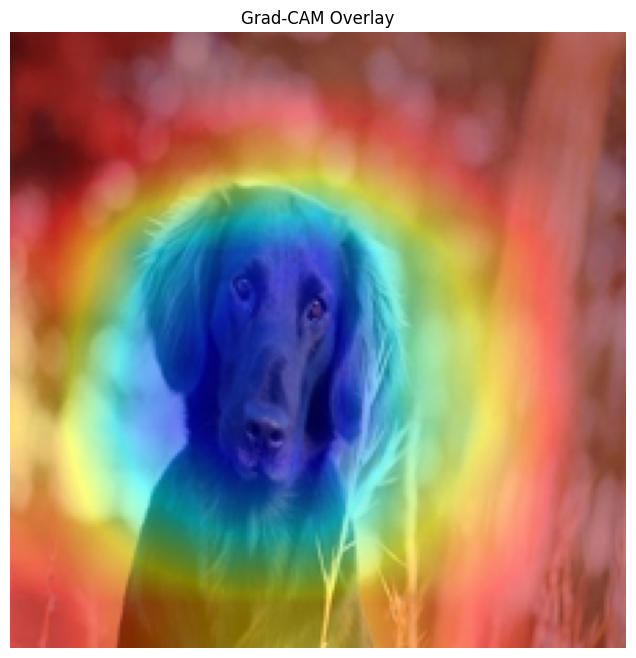

In [59]:
import torch
import torch.nn.functional as F
from torchvision import transforms, models
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None

        self.target_layer.register_forward_hook(self.save_activation)
        self.target_layer.register_full_backward_hook(self.save_gradient)

    def save_activation(self, module, input, output):
        self.activations = output.detach()

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def generate_cam(self):
        device = self.activations.device
        gradients = self.gradients.to(device)
        activations = self.activations.to(device)

        weights = torch.mean(gradients, dim=[2, 3])
        cam = torch.zeros(activations.shape[2:], dtype=torch.float32, device=device)

        for i, w in enumerate(weights[0]):
            cam += w * activations[0, i]

        cam = torch.relu(cam)
        cam = cam / torch.max(cam)
        cam = cam.cpu().numpy()

        # Увеличиваем карту до размера 224x224
        cam = cv2.resize(cam, (224, 224))
        return cam

def visualize_grad_cam(image_path, model, target_layer):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    
    image = Image.open(image_path).convert("RGB")
    device = next(model.parameters()).device
    image_tensor = transform(image).unsqueeze(0).to(device)

    grad_cam = GradCAM(model, target_layer)

    model.eval()
    output = model(image_tensor)

    class_idx = output.argmax().item()
    model.zero_grad()
    output[0, class_idx].backward()

    cam = grad_cam.generate_cam()

    
    image_np = np.array(image.resize((224, 224)))
    
    # Переводим карту активаций в RGB
    heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
    
    # Накладываем Grad-CAM поверх изображения
    overlay = cv2.addWeighted(image_np, 0.5, heatmap, 0.5, 0)

    plt.figure(figsize=(8, 8))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Grad-CAM Overlay")
    plt.show()


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT).to(device)
target_layer = model.layer4[1].conv2

image_path = r"C:\Users\madik\OneDrive\Рабочий стол\Images\n02099267-flat-coated_retriever\n02099267_721.jpg"


visualize_grad_cam(image_path, model, target_layer)

